# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [33]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint
import dataclasses

import pandas as pd
import numpy as np
import numpy.typing as npt
from scipy import linalg
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import scopus.biblio_extractor as bex
import catk

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (16.54, 11.7)})


DATASET_FILENAME = Path("results/pharmaco_chemistry_cross_2022-05-19_17-18-20.csv")
# DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")

SEED = 42


DATASET_FILENAME.stem = 'pharmaco_chemistry_cross_2022-05-19_17-18-20' DATASET_FILENAME.suffix = '.csv'


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_{ij}$ is of the form :
\begin{bmatrix}
FF & FT\\
TF & TT
\end{bmatrix}

Where :

- $FF = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $FT = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $TF = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $TT = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $FF + FT$ and $TF + TT$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $FF + TF$ and $FT + TT$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $FF + FT + TF + TT = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [34]:
dataset, margin_rows, margin_cols, number_of_papers = bex.load_results(DATASET_FILENAME)
all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

print(f"The domain contains {number_of_papers} papers")
display(dataset)


The domain contains 250082 papers


abiotic         \
                                                          antioxidant          
                                                                  w/o     w/   
alkaloid          acridine                            w/o      183327  64005   
                                                      w/         2475    275   
                  benzylamine                         w/o      185015  64207   
                                                      w/          787     73   
                  colchicine                          w/o      180095  64077   
...                                                               ...    ...   
terpenoid/terpene sesterterpene                       w/          186      7   
                  tetraterpene/carotenoid/xanthophyll w/o      182734  56504   
                                                      w/         3068   7776   
                  triterpene                          w/o      181206  63075   
                                                      w/         4596   1205   

                                                                         \
                                                          drought         
                                                              w/o    w/   
alkaloid          acridine                            w/o  246196  1136   
                                                      w/     2748     2   
                  benzylamine                         w/o  248084  1138   
                                                      w/      860     0   
                  colchicine                          w/o  243038  1134   
...                                                           ...   ...   
terpenoid/terpene sesterterpene                       w/      193     0   
                  tetraterpene/carotenoid/xanthophyll w/o  238462   776   
                                                      w/    10482   362   
                  triterpene                          w/o  243146  1135   
                                                      w/     5798     3   

                                                                   ...  \
                                                            metal  ...   
                                                              w/o  ...   
alkaloid          acridine                            w/o  221650  ...   
                                                      w/     2491  ...   
                  benzylamine                         w/o  223450  ...   
                                                      w/      691  ...   
                  colchicine                          w/o  218319  ...   
...                                                           ...  ...   
terpenoid/terpene sesterterpene                       w/      193  ...   
                  tetraterpene/carotenoid/xanthophyll w/o  213902  ...   
                                                      w/    10239  ...   
                  triterpene                          w/o  218392  ...   
                                                      w/     5749  ...   

                                                          pharmaco          \
                                                          sedative   wound   
                                                                w/     w/o   
alkaloid          acridine                            w/o     2503  240364   
                                                      w/         8    2671   
                  benzylamine                         w/o     2505  242195   
                                                      w/         6     840   
                  colchicine                          w/o     2477  237349   
...                                                            ...     ...   
terpenoid/terpene sesterterpene                       w/         1     191   
                  tetraterpene/carotenoid/xanthophyll w/o     2507  23229

### Extractiong the  "w/, w/" matrix

We can extract the 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [35]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
display(with_with_matrix)


abiotic          \
                                                      antioxidant drought   
alkaloid          acridine                                    275       2   
                  benzylamine                                  73       0   
                  colchicine                                  203       4   
                  cyclopeptide                                 58       1   
                  imidazole                                  1101       8   
...                                                           ...     ...   
terpenoid/terpene polyterpene                                   0       0   
                  sesquiterpene                               897      20   
                  sesterterpene                                 7       0   
                  tetraterpene/carotenoid/xanthophyll        7776     362   
                  triterpene                                 1205       3   

                                                                        ...  \
                                                      metal  salt   uv  ...   
alkaloid          acridine                              259   163   81  ...   
                  benzylamine                           169    82   25  ...   
                  colchicine                             88   190   21  ...   
                  cyclopeptide                          169    37   16  ...   
                  imidazole                            2591  1207  312  ...   
...                                                     ...   ...  ...  ...   
terpenoid/terpene polyterpene                             0     0    0  ...   
                  sesquiterpene                          72    60   42  ...   
                  sesterterpene                           0     3    0  ...   
                  tetraterpene/carotenoid/xanthophyll   605   527  404  ...   
                  triterpene                             52    60   46  ...   

                                                      pharmaco             \
                                                       obesity rheumatism   
alkaloid          acridine                                   3          0   
                  benzylamine                               35          0   
                  colchicine                               180         20   
                  cyclopeptide                              47          7   
                  imidazole                                300          1   
...                                                        ...        ...   
terpenoid/terpene polyterpene                                0          0   
                  sesquiterpene                             52          0   
                  sesterterpene                              1          0   
                  tetraterpene/carotenoid/xanthophyll      436          1   
                  triterpene                               134          2   

                                                                     toxicity  
                                                      sedative wound toxicity  
alkaloid          acridine                                   8    79      415  
                  benzylamine                                6    20      102  
                  colchicine                                34   224      871  
                  cyclopeptide                               4    51      177  
                  imidazole                                491   474     1796  
...                                                        ...   ...      ...  
terpenoid/terpene polyterpene                                0     0        2  
                  sesquiterpene                             30   135      349  
                  sesterterpene                              1     2       12  
                  tetraterpene/carotenoid/xanthophyll        4   100      849  
                  triterpene                                22   2

## Analyzing data

### Extracting the (confusion) submatrices

Lets illustrate the content of this table. The **2 by 2 submatrix** about _acridine_ and _cytotoxicity_ is as follows.


In [36]:
acridine_cytotoxicity_submatrix = dataset.loc[
    ("alkaloid", "acridine"),
    ("pharmaco", "cytotoxicity"),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"- {acridine_cytotoxicity_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The acridine and cytotoxicity confusion matrix is as follows")
display(acridine_cytotoxicity_submatrix)


Among 250082 papers, there are
- 207150 papers w/o acridine and w/o cytotoxicity in their keywords
- 40182 papers w/o acridine and w/ cytotoxicity in their keywords
- 1423 papers w/ acridine and w/o cytotoxicity in their keywords
- 1327 papers w/ acridine and w/ cytotoxicity in their keywords
The acridine and cytotoxicity confusion matrix is as follows


,w/o,w/
w/o,207150,40182
w/,1423,1327


### Metrics

We given different metrics to be applied on 2x2 submatrices, see the usual one for _confusion matrix_ in <https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion>

In [37]:
# def intersection_metric(arr):
#     """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
#     [FF, FT], [TF, TT] = arr.reshape(2, 2)
#     return TT / (FF + FT + TF + TT)


def tt_projection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


def odds_metric(arr):
    """The odds of having related keywords."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF * TT + 0.5) / (FT * TF + 0.5)


def logodds_metric(arr):
    """The log odds of having related keywords."""
    return np.log(odds_metric(arr))


metrics = [
    tt_projection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    fraction_metric,
    odds_metric,
    # logodds_metric,
]


print("An example on the acridine/cytotoxicity submatrix, its score for each metric")
print(acridine_cytotoxicity_submatrix)

for metric in metrics:
    print(f"- {metric.__name__:<22} = {metric(acridine_cytotoxicity_submatrix.values)}")


An example on the acridine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  207150  40182
w/     1423   1327
- tt_projection_metric   = 1327
- row_implication_metric = 0.48254545454545456
- col_implication_metric = 0.031968970584692474
- fowlkes_mallows_metric = 0.12420338740203786
- fraction_metric        = 0.03294602512537862
- odds_metric            = 4.807501274965761


**Remark** we'd love to say that "acridine  _partly implies_ cytotoxicity " ! Among 33 activities, about 48% of papers about acridine are about cytotoxicity !

### Applying the metrics

First, we filter out rows and cols with too few papers, we ask for at leat 0.1% of the total number of papers.
From now on, we'll stick to the **filtered dataset**.

In [38]:
ROW_THRESHOLD = number_of_papers // 1000
COL_THRESHOLD = number_of_papers // 1000
print(f"Thresholds for rows={ROW_THRESHOLD} and cols={COL_THRESHOLD}")

rows_filter = margin_rows.xs(bex.SELECTORS[1], level=2) >= ROW_THRESHOLD
cols_filter = margin_cols.xs(bex.SELECTORS[1], level=2) >= COL_THRESHOLD
filtered = dataset.loc[rows_filter, cols_filter]
filtered.index.name = "Compounds"
filtered.columns.name = "Activities"
display(filtered)

Thresholds for rows=250 and cols=250


abiotic         \
                                                          antioxidant          
                                                                  w/o     w/   
alkaloid          acridine                            w/o      183327  64005   
                                                      w/         2475    275   
                  benzylamine                         w/o      185015  64207   
                                                      w/          787     73   
                  colchicine                          w/o      180095  64077   
...                                                               ...    ...   
terpenoid/terpene sesquiterpene                       w/         4679    897   
                  tetraterpene/carotenoid/xanthophyll w/o      182734  56504   
                                                      w/         3068   7776   
                  triterpene                          w/o      181206  63075   
                                                      w/         4596   1205   

                                                                         \
                                                          drought         
                                                              w/o    w/   
alkaloid          acridine                            w/o  246196  1136   
                                                      w/     2748     2   
                  benzylamine                         w/o  248084  1138   
                                                      w/      860     0   
                  colchicine                          w/o  243038  1134   
...                                                           ...   ...   
terpenoid/terpene sesquiterpene                       w/     5556    20   
                  tetraterpene/carotenoid/xanthophyll w/o  238462   776   
                                                      w/    10482   362   
                  triterpene                          w/o  243146  1135   
                                                      w/     5798     3   

                                                                   ...  \
                                                            metal  ...   
                                                              w/o  ...   
alkaloid          acridine                            w/o  221650  ...   
                                                      w/     2491  ...   
                  benzylamine                         w/o  223450  ...   
                                                      w/      691  ...   
                  colchicine                          w/o  218319  ...   
...                                                           ...  ...   
terpenoid/terpene sesquiterpene                       w/     5504  ...   
                  tetraterpene/carotenoid/xanthophyll w/o  213902  ...   
                                                      w/    10239  ...   
                  triterpene                          w/o  218392  ...   
                                                      w/     5749  ...   

                                                          pharmaco          \
                                                          sedative   wound   
                                                                w/     w/o   
alkaloid          acridine                            w/o     2503  240364   
                                                      w/         8    2671   
                  benzylamine                         w/o     2505  242195   
                                                      w/         6     840   
                  colchicine                          w/o     2477  237349   
...                                                            ...     ...   
terpenoid/terpene sesquiterpene                       w/        30    5441   
                  tetraterpene/carotenoid/xanthophyll w/o     2507  23229

For instance, let's apply the _row_implication_metric_ to the filtered dataset.

In [39]:
def apply_metric(data, func, write=False):
    C, A = len(data.index) // 2, len(data.columns) // 2
    values = np.moveaxis(data.values.reshape((C, 2, A, 2)), 1, -2).reshape((C * A, 4))
    matrix = np.apply_along_axis(func, 1, values).reshape((C, A))
    sub = data.xs(bex.SELECTORS[True], axis=0, level=2).xs(bex.SELECTORS[True], axis=1, level=2)
    df = pd.DataFrame(matrix, index=sub.index, columns=sub.columns)
    df.index.name = "Compounds"
    df.columns.name = "Activities"

    if write:
        filename = Path(f"{DATASET_FILENAME.stem}_{func.__namme__}{DATASET_FILENAME.suffix}")
        df.to_csv(Path("results") / filename)
    return df


apply_metric(filtered, row_implication_metric)


abiotic          \
                                                      antioxidant drought   
alkaloid          acridine                                  0.100   0.001   
                  benzylamine                               0.085   0.000   
                  colchicine                                0.034   0.001   
                  cyclopeptide                              0.021   0.000   
                  imidazole                                 0.065   0.000   
...                                                           ...     ...   
terpenoid/terpene diterpene                                 0.126   0.002   
                  monoterpene                               0.266   0.068   
                  sesquiterpene                             0.161   0.004   
                  tetraterpene/carotenoid/xanthophyll       0.717   0.033   
                  triterpene                                0.208   0.001   

                                                                         ...  \
                                                      metal  salt    uv  ...   
alkaloid          acridine                            0.094 0.059 0.029  ...   
                  benzylamine                         0.197 0.095 0.029  ...   
                  colchicine                          0.015 0.032 0.004  ...   
                  cyclopeptide                        0.062 0.014 0.006  ...   
                  imidazole                           0.154 0.072 0.019  ...   
...                                                     ...   ...   ...  ...   
terpenoid/terpene diterpene                           0.010 0.014 0.009  ...   
                  monoterpene                         0.019 0.017 0.012  ...   
                  sesquiterpene                       0.013 0.011 0.008  ...   
                  tetraterpene/carotenoid/xanthophyll 0.056 0.049 0.037  ...   
                  triterpene                          0.009 0.010 0.008  ...   

                                                          pharmaco          \
                                                      cytotoxicity obesity   
alkaloid          acridine                                   0.483   0.001   
                  benzylamine                                0.149   0.041   
                  colchicine                                 0.215   0.030   
                  cyclopeptide                               0.201   0.017   
                  imidazole                                  0.171   0.018   
...                                                            ...     ...   
terpenoid/terpene diterpene                                  0.401   0.011   
                  monoterpene                                0.176   0.005   
                  sesquiterpene                              0.375   0.009   
                  tetraterpene/carotenoid/xanthophyll        0.045   0.040   
                  triterpene                                 0.376   0.023   

                                                                     toxicity  
                                                      sedative wound toxicity  
alkaloid          acridine                               0.003 0.029    0.151  
                  benzylamine                            0.007 0.023    0.119  
                  colchicine                             0.006 0.038    0.147  
                  cyclopeptide                           0.001 0.019    0.065  
                  imidazole                              0.029 0.028    0.107  
...                                                        ...   ...      ...  
terpenoid/terpene diterpene                              0.002 0.020    0.090  
                  monoterpene                            0.004 0.018    0.149  
                  sesquiterpene                          0.005 0.024    0.063  
                  tetraterpene/carotenoid/xanthophyll    0.000 0.009    0.078  
                  triterpene            

Now, compute all given metrics with a short summary.

In [40]:
score_df = {}
for metric in metrics:
    metric_name = metric.__name__
    score_df[metric_name] = apply_metric(filtered, metric, False)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


,min,mean,max,std
tt_projection_metric,0.000,379.890,28632.000,1430.375
row_implication_metric,0.000,0.052,0.758,0.086
col_implication_metric,0.000,0.028,0.445,0.052
fowlkes_mallows_metric,0.000,0.028,0.506,0.042
fraction_metric,0.000,0.014,0.969,0.046
odds_metric,0.000,1.186,28.671,1.911


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

Now, we draw compounds and activities as scatterplots on the first 2 dimensions. For this one, we use the `catk` lib without further ado.

Coords (std)         \
                                                              1      2   
(abiotic, antioxidant)                                    1.660  0.074   
(abiotic, drought)                                        1.794 -0.211   
(abiotic, metal)                                         -0.197 -0.382   
(abiotic, salt)                                          -0.852 -1.349   
(abiotic, uv)                                             0.740 -0.177   
...                                                         ...    ...   
(terpenoid/terpene, diterpene)                           -0.576 -0.493   
(terpenoid/terpene, monoterpene)                          0.159  0.796   
(terpenoid/terpene, sesquiterpene)                       -0.490  0.132   
(terpenoid/terpene, tetraterpene/carotenoid/xan...        1.850 -0.270   
(terpenoid/terpene, triterpene)                          -0.305 -0.533   

                                                   Coords (princ.)         \
                                                                 1      2   
(abiotic, antioxidant)                                       0.797  0.026   
(abiotic, drought)                                           0.862 -0.074   
(abiotic, metal)                                            -0.095 -0.134   
(abiotic, salt)                                             -0.409 -0.474   
(abiotic, uv)                                                0.356 -0.062   
...                                                            ...    ...   
(terpenoid/terpene, diterpene)                              -0.277 -0.173   
(terpenoid/terpene, monoterpene)                             0.077  0.280   
(terpenoid/terpene, sesquiterpene)                          -0.235  0.046   
(terpenoid/terpene, tetraterpene/carotenoid/xan...           0.888 -0.095   
(terpenoid/terpene, triterpene)                             -0.146 -0.187   

                                                   Contributions (%)  ...  \
                                                                   1  ...   
(abiotic, antioxidant)                                        62.266  ...   
(abiotic, drought)                                             1.135  ...   
(abiotic, metal)                                               0.287  ...   
(abiotic, salt)                                                2.858  ...   
(abiotic, uv)                                                  1.080  ...   
...                                                              ...  ...   
(terpenoid/terpene, diterpene)                                 0.376  ...   
(terpenoid/terpene, monoterpene)                               0.007  ...   
(terpenoid/terpene, sesquiterpene)                             0.469  ...   
(terpenoid/terpene, tetraterpene/carotenoid/xan...            12.062  ...   
(terpenoid/terpene, triterpene)                                0.183  ...   

                                                   Cosine²        Quality (%)  \
                                                         1      2               
(abiotic, antioxidant)                              99.894  0.106      62.390   
(abiotic, drought)                                  99.263  0.737       1.150   
(abiotic, metal)                                    33.249 66.751       1.363   
(abiotic, salt)                                     42.703 57.297      10.027   
(abiotic, uv)                                       97.040  2.960       1.141   
...                                                    ...    ...         ...   
(terpenoid/terpene, diterpene)                      71.896 28.104       0.650   
(terpenoid/terpene, monoterpene)                     6.975 93.025       0.185   
(terpenoid/terpene, sesquiterpene)                  96.267  3.733       0.503   
(terpenoid/terpene, tetraterpene/carotenoid/xan...  98.877  1.123      12.318   
(terpenoid/terpene, triterpene)                     37.912 62.088       0.743   

                              

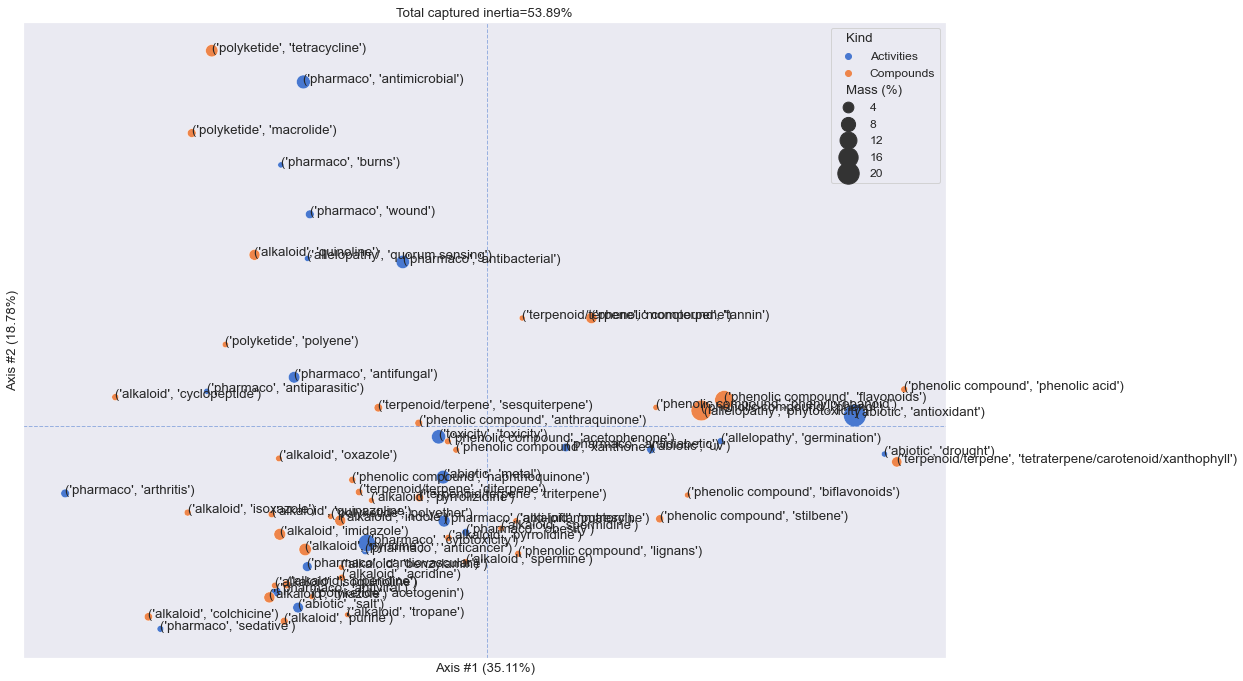

In [41]:
ca = catk.ca.CA(SEED)
ca.fit(score_df["tt_projection_metric"])
display(ca.contributions(K = 2))
ca.plot(coords=("standard", "standard"))
plt.show()


In [ ]:



for f_name, df in score_df.items():
    print(f"Drawing for {f_name}")
    ca = catk.ca.CA(SEED)
    ca.fit(df)
    # first 2 axes
    res = ca.contributions(K = 2)
    
    # ca.plot()
    # plt.show()
    # ca_res = correspondence_analysis(df)
    # axis = None
    # if f_name == "row_implication_metric":
    #     axis = 0
    # if f_name == "col_implication_metric":
    #     axis = 1
    # plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates, axis=axis)

    # ax = sns.scatterplot(data=plot_ca, x="1st axis", y="2nd axis", hue="class", size="mass", sizes=(64, 512))
    # ax.set_title(
    #     f"CA for {f_name}, captured inertia={100*ca_res.inertias[:2].sum():.2f}% {f'(only {axis = })' if axis is not None else ''}"
    # )
    # ax.set_xlabel(f"1st axis ({100*ca_res.inertias[0]:.2f})")
    # ax.set_ylabel(f"2nd axis ({100*ca_res.inertias[1]:.2f})")
    # for index, row in plot_ca.iterrows():
    #     ax.annotate(index, (row["1st axis"] + SHIFT, row["2nd axis"] + SHIFT))
    # plt.show()


## Implication rules

We summarize the top _k_ _row to col_ and _col to row_ implications.

In [ ]:
def clean_implications(axis=0):
    if axis == 0:
        f_name = "row_implication_metric"
    elif axis == 1:
        f_name = "col_implication_metric"
    else:
        raise IndexError(f"no such axis {axis}")

    df = score_df[f_name].copy()
    df_support = (
        score_df["tt_projection_metric"]
        .melt(ignore_index=False, value_name="value")
        .reset_index()
        .drop(columns=["level_0", "variable_0"], axis=1)
        .rename(columns={"level_1": "compound", "variable_1": "activity"})
        .set_index(["compound", "activity"])
    )

    df.index = df.index.droplevel(0)
    df.columns = df.columns.droplevel(0)
    df = df.melt(ignore_index=False, value_name="%").reset_index()
    df.set_index(["index", "variable"], inplace=True)
    df.index.set_names(["compound", "activity"], inplace=True)
    df["mass"] = df_support["value"]
    # df["support"] = df_support["value"] / df["%"]
    df.sort_values(by="%", ascending=False, inplace=True)
    return df


# clean_implications(axis = 0)


For instance, the first line states that 75.8% of papers with keyword _phenolic acid_ also have the _antioxidant_ keywords: are 1879 papers with both keywords out of 1879 + 600 about _phenolic acid_.

In [ ]:
NB_RULES_SHOWN = 20

print("Best implication rules : compound => activity")
display(clean_implications(0).head(NB_RULES_SHOWN))
print("phenolic acid/antioxidant submatrix")
display(dataset.loc[("phenolic compound", "phenolic acid"), ("abiotic", "antioxidant")])


Now, the other way around

In [ ]:
print("Best implication rule : activity => compound")
clean_implications(1).swaplevel().head(NB_RULES_SHOWN)